In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

In [3]:
project_data = pd.read_csv('results.csv')
project_data['AA_0'] = pd.to_numeric(project_data['AA_0'], errors='coerce')
project_data = project_data[["timestamp", "AA_0"]]
project_data.head()
# known_anomalies.head()


,timestamp,AA_0
0,2023-01-30 10:09:00,499.351958
1,2023-01-30 10:10:00,506.077377
2,2023-01-30 10:11:00,493.641609
3,2023-01-30 10:12:00,490.433220
4,2023-01-30 10:13:00,501.908598


In [4]:
project_data['timestamp'][0]

'2023-01-30 10:09:00'

In [5]:
from datetime import datetime

# Две строки с датами
date1_str = project_data['timestamp'][0]
for i in range(project_data.shape[0]):
    date2_str = project_data['timestamp'].iloc[i]

    # Преобразование строк в datetime объекты
    date1 = datetime.strptime(date1_str, "%Y-%m-%d %H:%M:%S")
    date2 = datetime.strptime(date2_str, "%Y-%m-%d %H:%M:%S")

    # Перевод в UNIX-время (в секундах с 1 января 1970 года)
    timestamp1 = int(date1.timestamp())
    timestamp2 = int(date2.timestamp())

    # Разница во времени в секундах
    difference_in_seconds = timestamp2 - timestamp1
    project_data['timestamp'][i] = difference_in_seconds

# df['timestamp'].head()
# Вывод результата
print(f"Timestamp 1: {timestamp1} секунд {date1_str}")
print(f"Timestamp 2: {timestamp2} секунд{date2_str}")
print(f"Разница: {difference_in_seconds} секунд")


C:\Users\aidar\AppData\Local\Temp\ipykernel_21892\64004259.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_data['timestamp'][i] = difference_in_seconds


Timestamp 1: 1675062540 секунд 2023-01-30 10:09:00
Timestamp 2: 1686826200 секунд2023-06-15 13:50:00
Разница: 11763660 секунд


In [6]:
a = project_data['timestamp'].tolist()
b = project_data['AA_0'].tolist()
a
data = {'timestamp': a, 'value': b}
df = pd.DataFrame(data)

In [7]:
df[195000:196062]

,timestamp,value
195000,11700000,535.184837
195001,11700060,536.967111
195002,11700120,540.953397
195003,11700180,538.296096
195004,11700240,528.901715
...,...,...
196057,11763420,536.814490
196058,11763480,529.501415
196059,11763540,533.936261
196060,11763600,540.968899


In [8]:
data = {'start': [8550000, 11700000], 'end': [8654940, 11763660]}
known_anomalies = pd.DataFrame(data)
known_anomalies

,start,end
0,8550000,8654940
1,11700000,11763660


d:\MIREAProjects\hackaton\utils.py:145: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


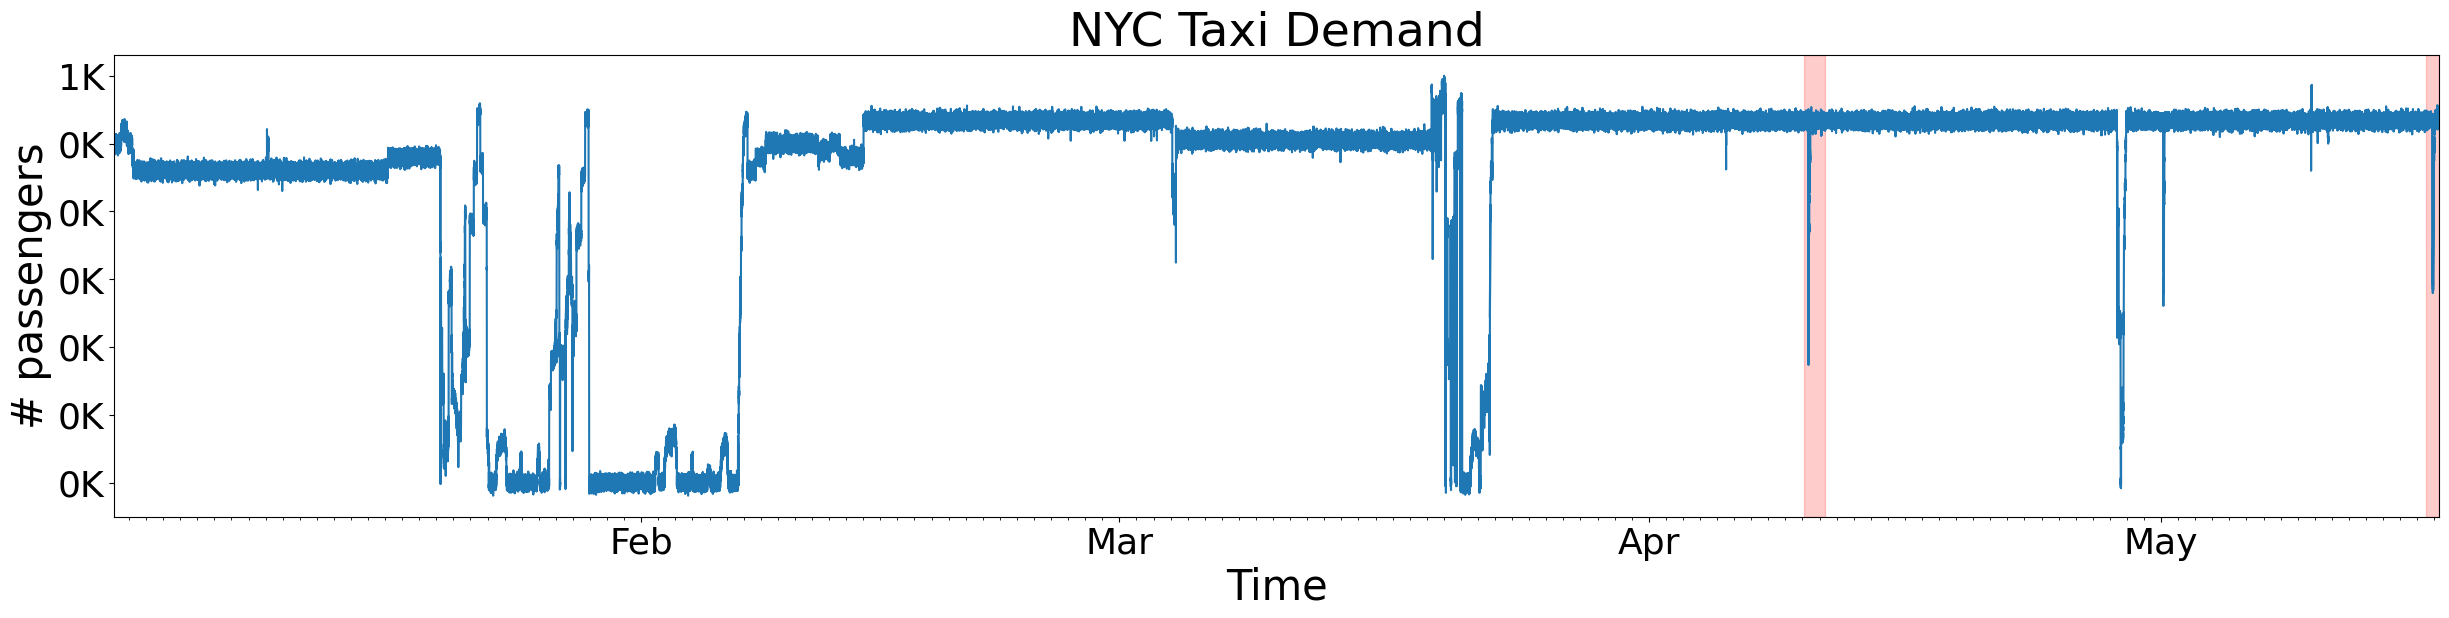

In [9]:
plot(df, known_anomalies)

In [10]:
from orion import Orion


orion = Orion(
    pipeline='tadgan.json'
)

anomalies = orion.fit_detect(df)

Epoch: 1/2, Losses: {'cx_loss': 7.5277, 'cz_loss': 1.4091, 'eg_loss': 7.9504}
Epoch: 2/2, Losses: {'cx_loss': 2.7882, 'cz_loss': 2.2633, 'eg_loss': 7.2988}
14/14 [==============================] - 0s 18ms/step


d:\MIREAProjects\hackaton\utils.py:145: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


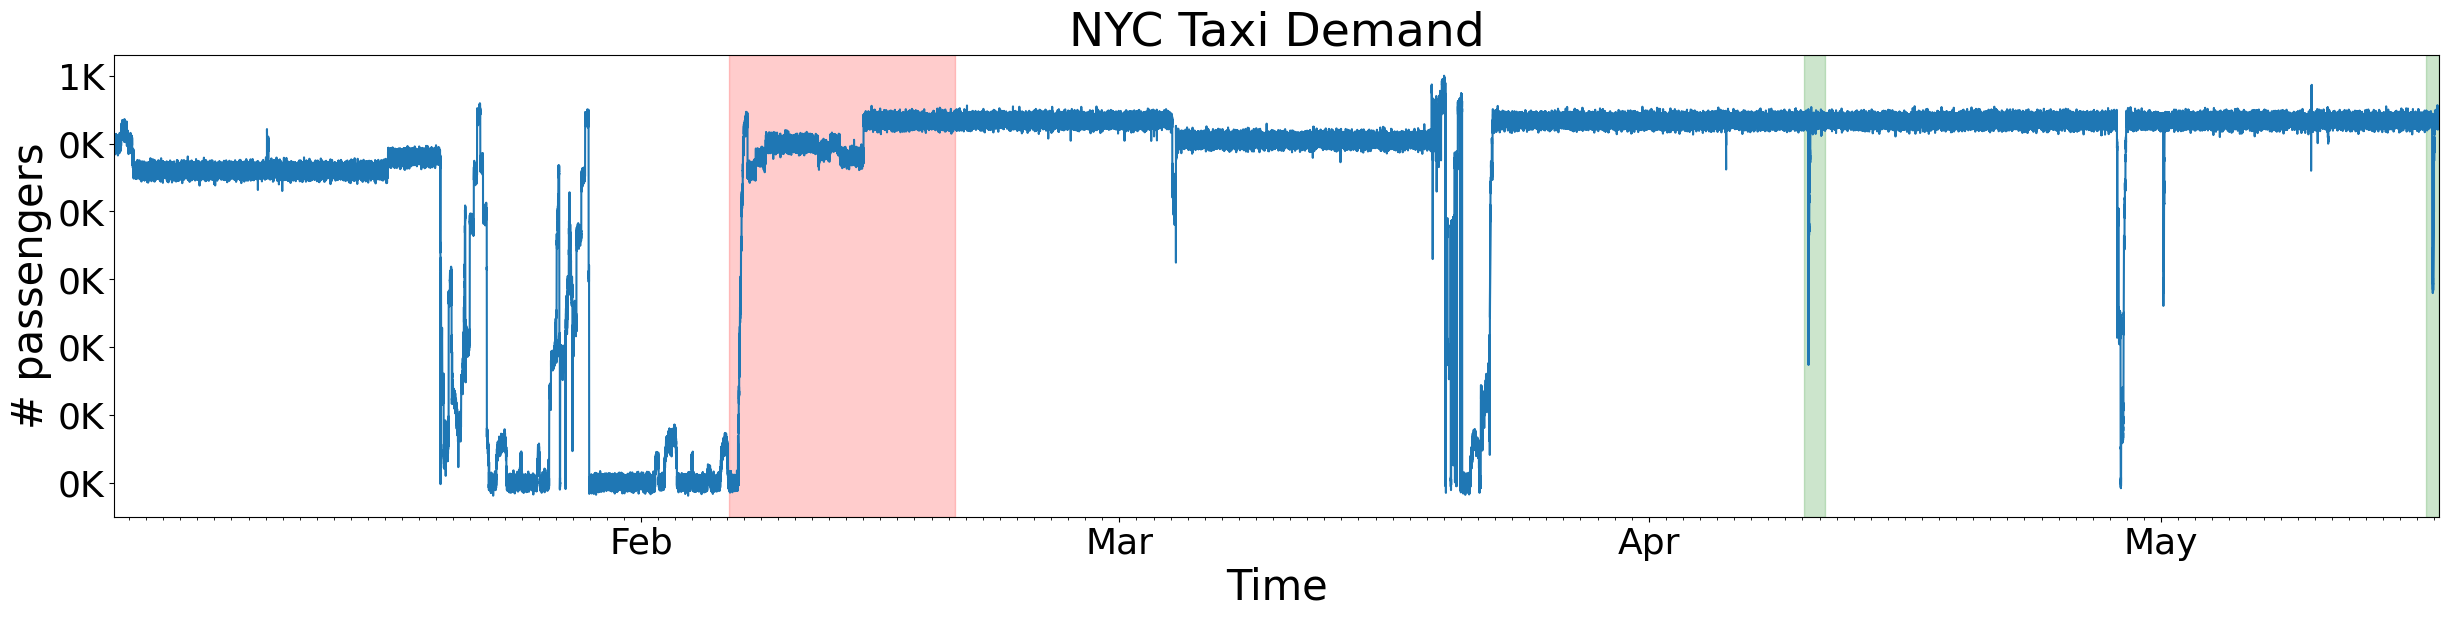

,start,end,severity
0,3110400,4255200,0.376752


In [11]:
plot(df, [anomalies, known_anomalies])
anomalies.head(5)

In [12]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(df, interval=1800, time_column='timestamp')


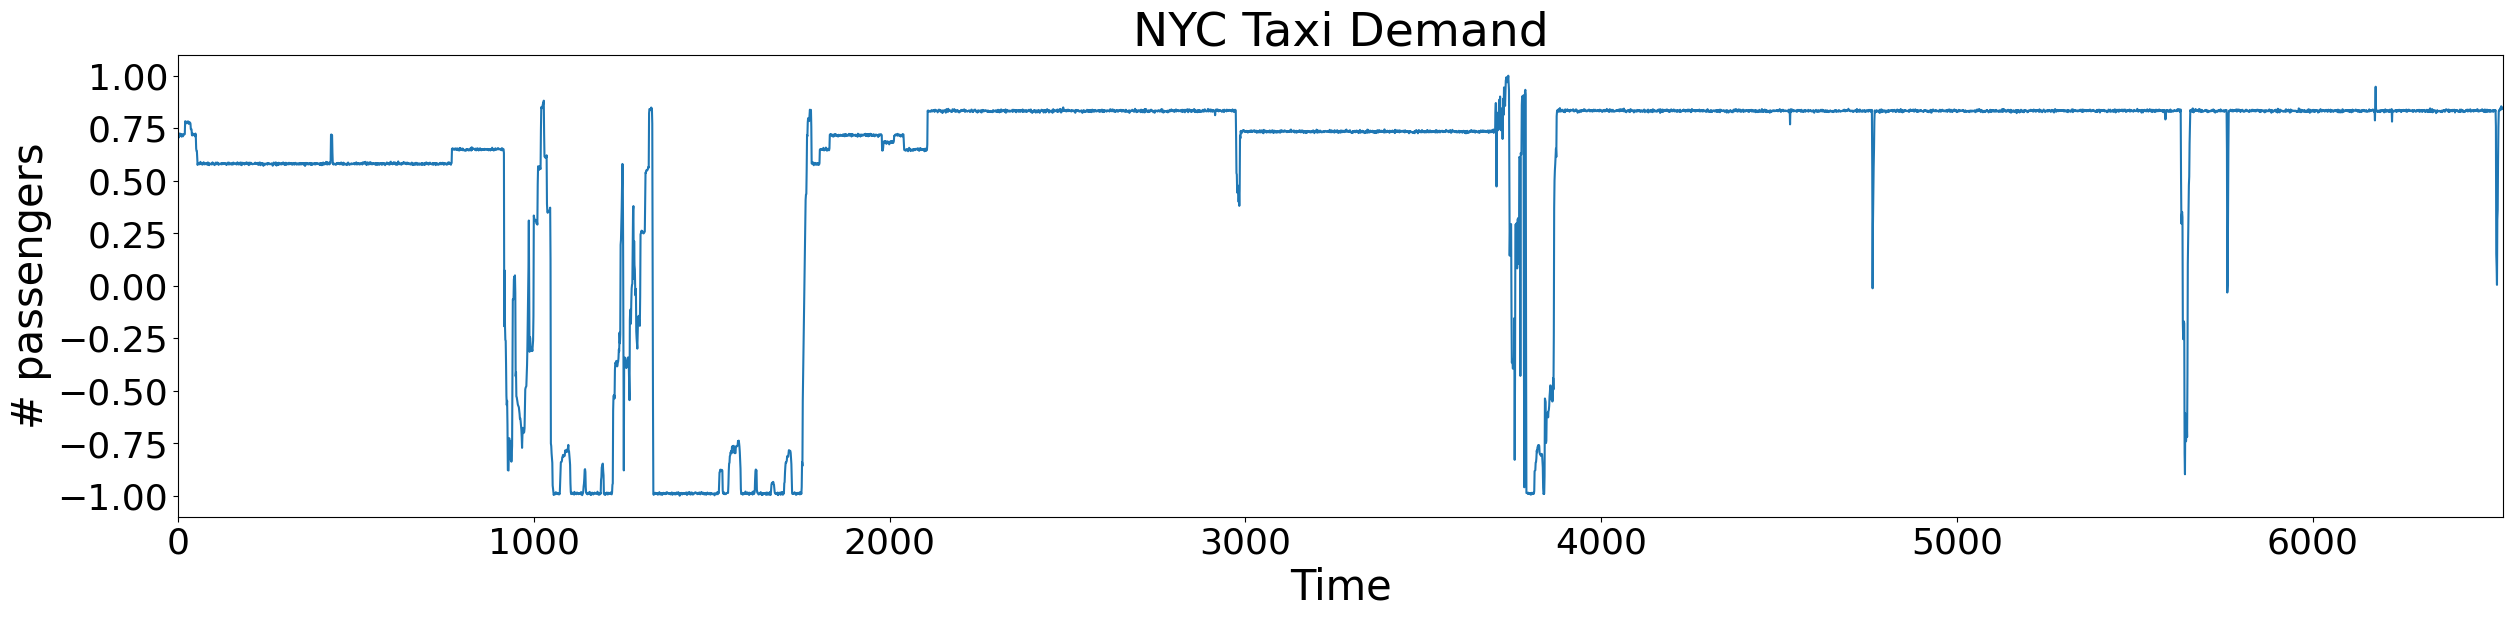

In [13]:
imp = SimpleImputer()
X = imp.fit_transform(X)
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
plot_ts(X)



In [14]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)


Training data input shape: (6436, 100, 1)
Training data index shape: (6436,)
Training y shape: (6436, 1)
Training y index shape: (6436,)


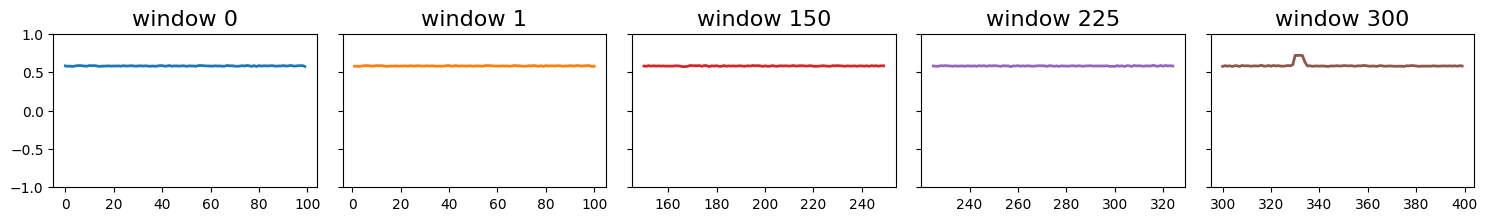

In [15]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))
plot_rws(X)


In [16]:
from model import hyperparameters
from orion.primitives.tadgan import TadGAN

hyperparameters["epochs"] = 2
hyperparameters["input_shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "tensorflow.keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

Epoch: 1/2, Losses: {'cx_loss': -4.6591, 'cz_loss': -2.261, 'eg_loss': 1.8255}
Epoch: 2/2, Losses: {'cx_loss': -2.3297, 'cz_loss': -4.7871, 'eg_loss': -10.0365}


202/202 [==============================] - 5s 25ms/step


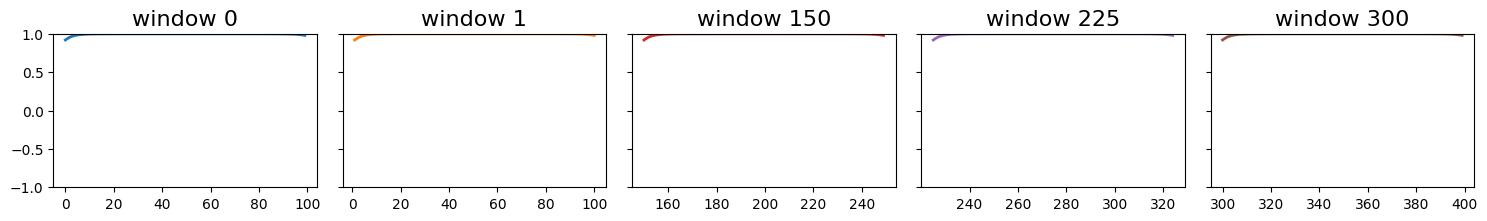

In [17]:
X_hat, critic = tgan.predict(X)

# visualize X_hat
plot_rws(X_hat)


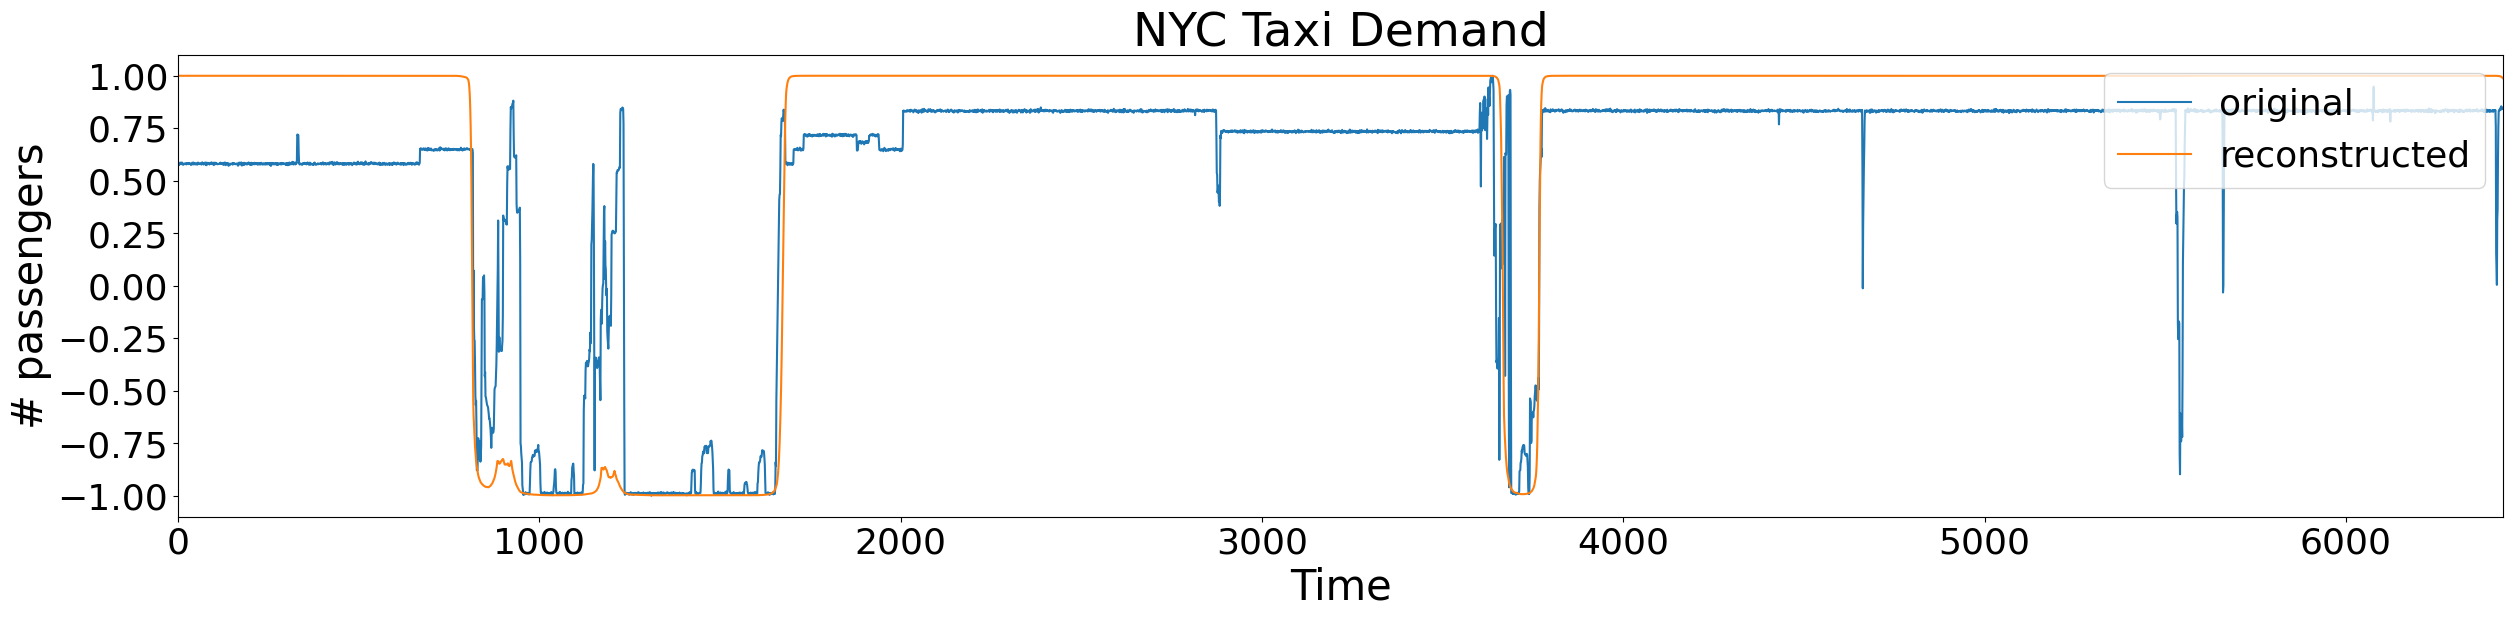

In [18]:
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])


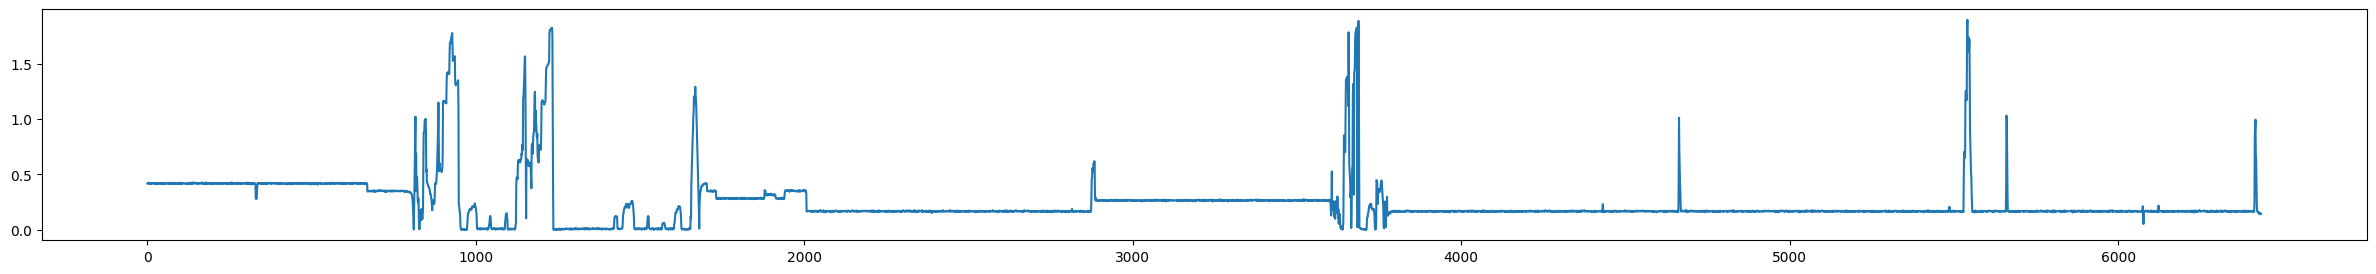

In [19]:
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()


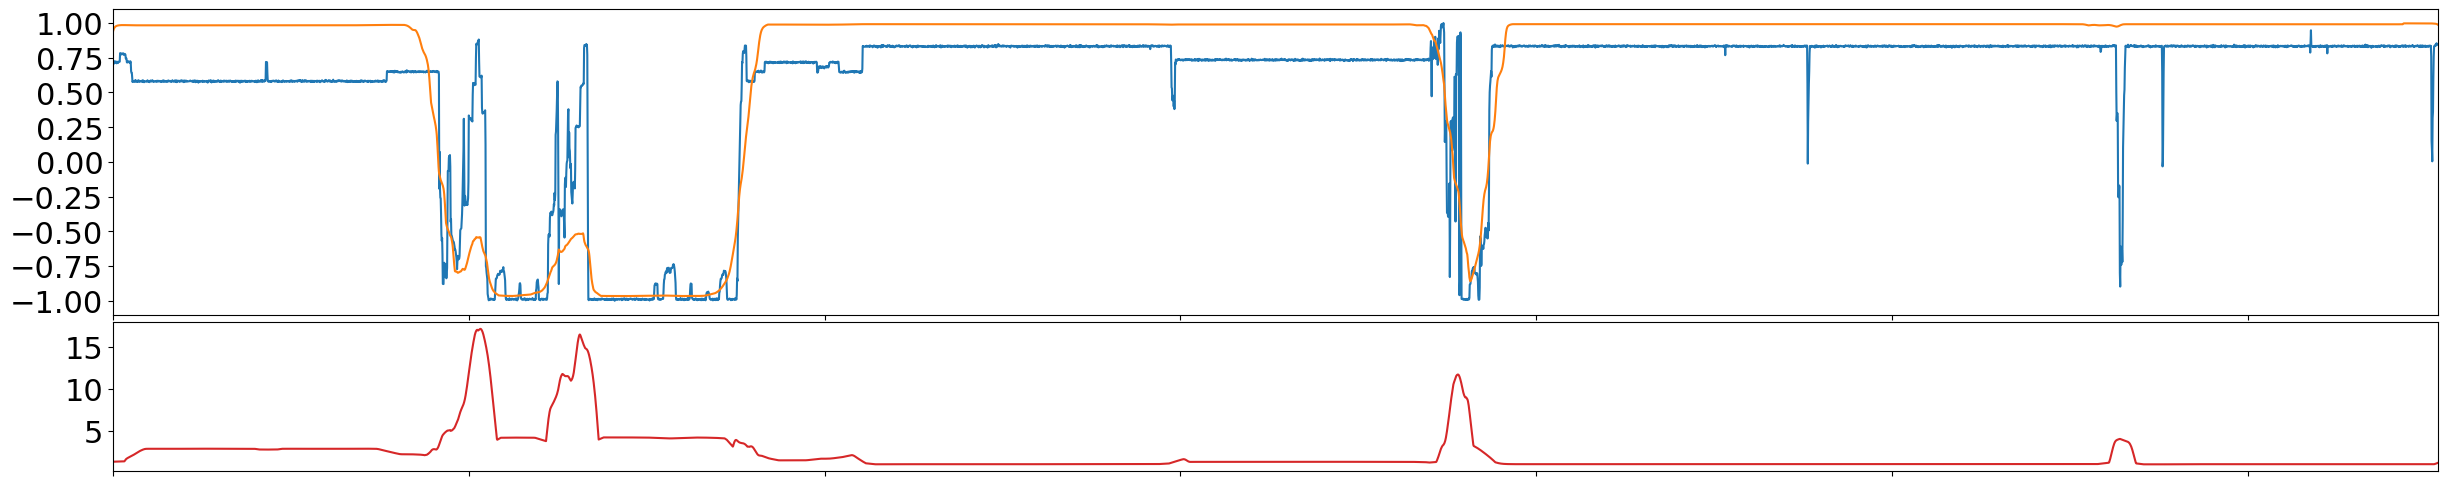

In [20]:
from orion.primitives.tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

In [21]:
# threshold
thresh = 10

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while i < len(error) and error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals


[(1789200, 1917000, 14.642996728941354),
 (2253600, 2435400, 13.001352048401513),
 (6777000, 6827400, 11.060589781788357)]

d:\MIREAProjects\hackaton\utils.py:145: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


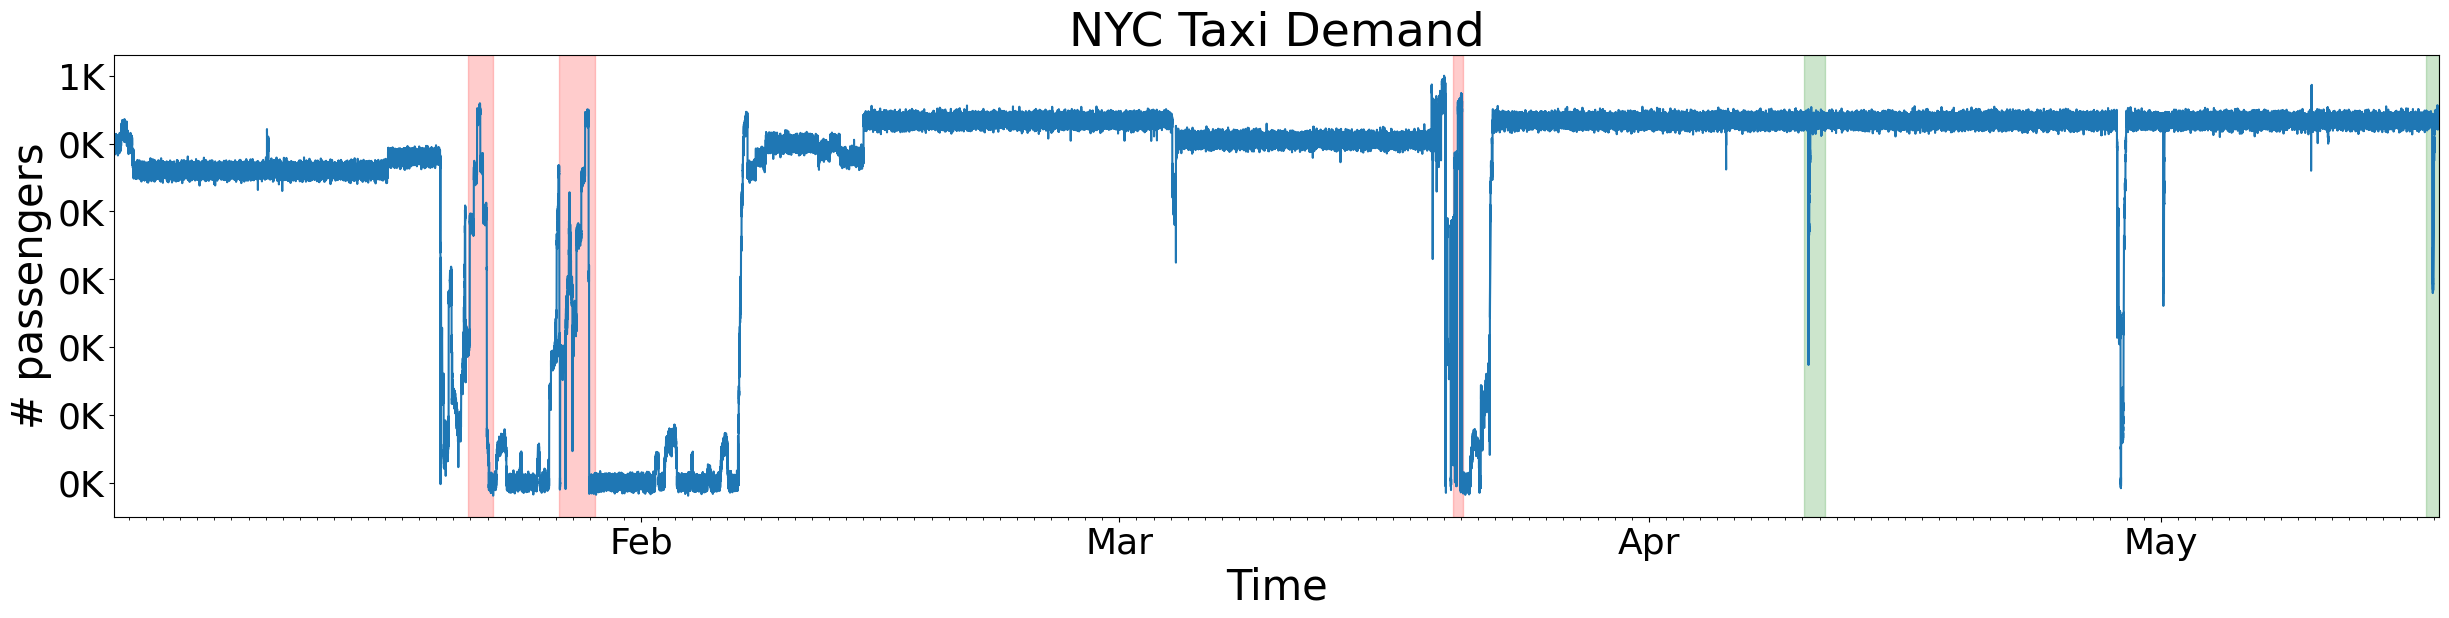

In [22]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])


In [23]:
from orion.primitives.timeseries_anomalies import find_anomalies

# find anomalies
intervals = find_anomalies(error, index, 
                           window_size_portion=0.33, 
                           window_step_size_portion=0.1, 
                           fixed_threshold=True)
intervals


array([[2.25180000e+06, 2.51640000e+06, 7.34055122e-01],
       [6.67260000e+06, 6.94980000e+06, 1.40554477e+00],
       [1.00260000e+07, 1.03032000e+07, 7.53956367e-01]])

d:\MIREAProjects\hackaton\utils.py:145: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


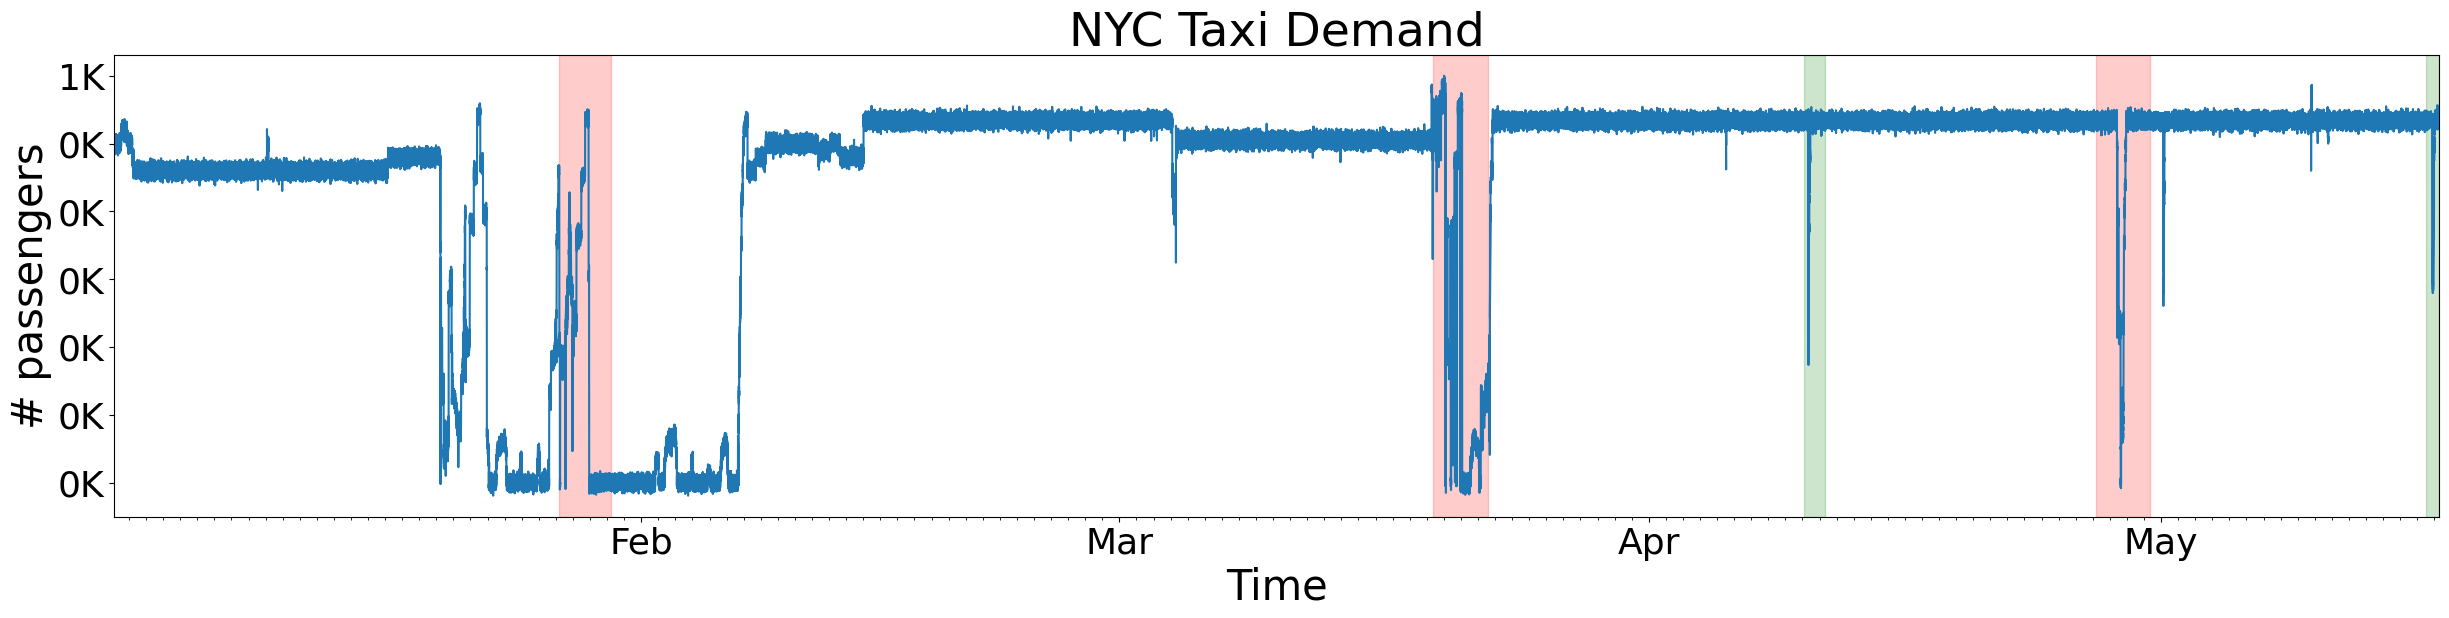

In [24]:
# visualize the result
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])
